# HW 3 (due December 02 23:59 MSK)

In [314]:
import math
import sympy
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple
from random import randint, randrange

### Problem 1 (1 point)

Diffie–Hellman key exchange protocol is one of the earliest practical examples of public key exchange implemented within the field of cryptography. Published in 1976 by Diffie and Hellman, this is the earliest publicly known work that proposed the idea of a private key and a corresponding public key. 

1) Implement function to generate common secret key within multiplicative group of given Finite field with known generator 

In [421]:
# A = g^a mod p
# B = g^b mod p
# K = B^a mod p = A^b mod p = g^ab mod p

def diffie_hellman(p: int, g: int, a: int, b: int) -> int:
    return pow(g, a * b, p)

2) Test your solution in GF(17) with generator g=11. Bobs' open key B=11, Alice private key is a=7

Bob's open key is equal to 11. $B = g^b mod p \Rightarrow$  $11 = 11^b mod 17 \Rightarrow$ $b$ is equal to 1.

In [422]:
diffie_hellman(p=17, g=11, a=7, b=1)

3

We can check the answer using another formula where $K = B^a mod p$, as we initially have Bob's open key and Alice private key:

In [423]:
assert(diffie_hellman(p=17, g=11, a=7, b=1) == pow(11, 7, 17))

### Problem 2 (3 points)

El Gamal protocol is widely used in cryptography. In this task we will ask you to implement your own El-Gamal encryption scheme on Python

1) Implement function for generating keys. The function must generate big random prime number (problem of generating big prime numbers was discussed within the lectures). (1 point)

In [71]:
def get_n_bit_random_number(n: int) -> int:
    return randrange(2**(n - 1) + 1, 2**n - 1)

def generate_prime_candidate(n: int) -> int:
    first_primes: set = set([x for x in range(2, 256) if all(x % y != 0 for y in range(2, x - 1))])
    
    while True:
        prime_candidate: int = get_n_bit_random_number(n)
        for prime in first_primes:
            if prime_candidate % prime == 0 and prime**2 <= prime_candidate:
                break
        else:
            return prime_candidate

def is_prime_miller_rabin(n: int, k: int) -> bool:
    if 2 <= n <= 3:
        return True
    if n < 2 or n % 2 == 0:
        return False
    
    r: int = 0
    s: int = n - 1
        
    while s % 2 == 0:
        s //= 2
        r += 1
        
    for _ in range(k):
        a: int = randrange(2, n - 1)
        x: int = pow(a, s, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(r - 1):
            x: int = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
        
    return True

def generate_big_random_prime(n: int = 2**10, k: int = 2**7) -> int:
    probably_prime: int = generate_prime_candidate(n)
    while not is_prime_miller_rabin(probably_prime, k):
        probably_prime = generate_prime_candidate(n)
    
    return probably_prime
    
def generate_keys(n: int = 2**10, k: int = 2**7) -> (int, int, int, int):
    p: int = generate_big_random_prime(n, k)
    g: int = randrange(1, p)
    x: int = randrange(2, p - 1)
    y: int = pow(g, x, p)
        
    return p, g, x, y

In [65]:
# let's check that generated numbers are truly prime using sympy lib
primes: int = 0
for _ in range(100):
    if sympy.isprime(generate_big_random_prime()):
        primes += 1

print(f'percentage of prime numbers: {primes / 100.0}%')

percentage of prime numbers: 1.0%


2) Implement functions that realize the encryption and decryption in El Gamal protocol. (1 points)

In [72]:
def encrypt(m: int) -> (int, int, int, int):
    p, g, x, y = generate_keys()
    
    if m >= p:
        raise ValueError(f'm should be smaller than {p}')

    k: int = randrange(2, p - 1)
    a: int = pow(g, k, p)
    b: int = (pow(y, k, p) * m) % p
        
    return a, b, p, x

In [73]:
def decrypt(a: int, b: int, p: int, x: int) -> int:
    return (pow(a, p - 1 - x, p) * b) % p

3) Calculate Hash of your name by SHA-1 and test El Gamal encryption/decryption functions on it (1 points)

In [78]:
name_hash: int = int(hashlib.sha1('Maria Manakhova'.encode('utf-8')).hexdigest(), 16)

In [79]:
%time
a, b, p, x = encrypt(name_hash)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [80]:
%time
decrypted_hash: int = decrypt(a, b, p, x)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.05 µs


In [81]:
print(f'hash of the name: {name_hash}')
print(f'decrypted result: {decrypted_hash}')
assert(name_hash == decrypted_hash)

hash of the name: 1179600700976080383758295249782161755223890467903
decrypted result: 1179600700976080383758295249782161755223890467903


<b>Generated name hash and decrypted result are equal, so El Gamal encryption / decryption algorithm works well.</b>

### Problem 3 (4 points)

Elliptic curves due to their efficient hardware realization widely used in modern secure communication channels. The main thing that lies inside their cryptographic hardness is that we can break them only by greed search over all group points. In this task, we will ask you to write python function that returns all group elements of a certain elliptic curve over a finite field 

1) Write a python function that list all points of elliptic curve $y^2=x^3+7$ over $F_{127}$ (1 points)

*Note. $127 = 2^7-1$ is the fourth Mersenne prime.*

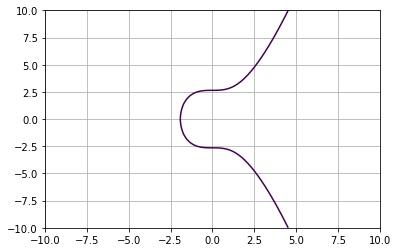

In [125]:
    c: int = 7
    y, x = np.ogrid[-10:10:100j, -10:10:100j]
    plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - c, [0])
    plt.grid()
    plt.show()

In [147]:
def on_curve(x: int, y: int, p: int) -> bool:
    return pow(y, 2, p) == (x**3 + 7) % p

# y^2 = x^3 + 7, as y^2 >= 0 -> x^3 + 7 >= 0 -> x^3 >= -7, so least possible values are -1 for x and 0 for y
def get_points_of_elliptic_curve(p: int) -> List[Tuple[int, int]]:
    points: List[Tuple[int, int]] = []
    for x in range(-1, p):
        for y in range(0, p):
            if on_curve(x, y, p):
                points.append((x, y))
    
    return points

points: List[Tuple[int, int]] = get_points_of_elliptic_curve(127)

In [149]:
pd.set_option('display.max_rows', None)  
points_table: pd.DataFrame = pd.DataFrame(points, columns =['x', 'y'])
points_table.head(len(points))

,x,y
0,1,32
1,1,95
2,2,53
3,2,74
4,3,62
5,3,65
6,4,43
7,4,84
8,8,30
9,8,97


2) Compare the number of points with Hasse’s estimate $|N-(q+1)|\leq 2{\sqrt  {q}}$. (1 point)

In [150]:
def check_hasses_estimate(q: int, N: int) -> bool:
    return abs(N - (q + 1)) <= 2 * math.sqrt(q)

print(check_hasses_estimate(127, len(points)))

True


3) Prove that the point
$A = (19, 32)$ belongs to the elliptic curve and construct a sequence of $B_n = nA, n = 1, ..., 100$. (2 points)

<center> put $x = 19, y = 32$ </center> <br>
$$ (32)^2 = (19)^3 + 7 (mod 127) $$ <br>
$$ 32^2 = 1024 = 8 \cdot 127 + 8 = 8 (mod 127)$$
$$ 19^3 + 7 = 6859 + 7 = 6866 = 54 \cdot 127 + 8 = 8 (mod 127) $$ <br>
$$ 8 = 8 (mod 127) $$ <br>

In [407]:
class EllipticCurvePoint(object):
    def __init__(self, x: int, y: int, p: int):
        self.x = x
        self.y = y
        self.p = p
        
    def __repr__(self):
        return f'({self.x}, {self.y})'
    
    def multiply_by_two(self) -> Point:
        m: int = (((3 * pow(self.x, 2, self.p)) % self.p) * pow(2 * self.y, -1, self.p)) % self.p
        x: int = (pow(m, 2, self.p) - (2 * self.x) % self.p) % self.p
        y: int = (-self.y % self.p + (m * (self.x - x)) % self.p) % self.p

        return EllipticCurvePoint(x, y, self.p)
    
    def add_point(self, point: Point) -> Point:
        m: int = (((self.y - point.y) % self.p) * pow(self.x - point.x, -1, self.p)) % self.p
        x: int = (pow(m, 2, self.p) - self.x - point.x) % self.p
        y: int = ((m * (self.x - x)) % self.p - self.y) % self.p
            
        return EllipticCurvePoint(x, y, self.p)

In [408]:
A: EllipticCurvePoint = EllipticCurvePoint(19, 32, 127)
b_sequence: List[EllipticCurvePoint] = [None] * 100
b_sequence[0] = A
b_sequence[1] = A.multiply_by_two()

for i in range(2, 100):
    b_sequence[i] = b_sequence[i - 1].add_point(A)
    assert(on_curve(b_sequence[i].x, b_sequence[i].y, 127))

In [415]:
sequence_table: pd.DataFrame = pd.DataFrame(b_sequence, columns = ['points'])
sequence_table.head(len(sequence_table))

,points
0,"(19, 32)"
1,"(11, 24)"
2,"(98, 16)"
3,"(123, 18)"
4,"(79, 64)"
5,"(110, 38)"
6,"(58, 38)"
7,"(38, 53)"
8,"(67, 62)"
9,"(91, 50)"


### Problem 4 (2 points)

Let $p = 601$, $q = 7$, $e = 1463$. Coompute encrypted message of the plane message $58$ with RSA algorithm.

In [83]:
def get_rsa_keys(p: int, q: int, e: int, M: int) -> ((int, int), (int, int)):
    def phi(p: int, q: int) -> int:
        return (p - 1) * (q - 1) 

    n: int = p * q
    phi_n: int = phi(p, q)
        
    assert(1 < e < phi_n)
    assert(math.gcd(e, phi_n) == 1)
    
    d: int = pow(e, -1, phi_n)
    
    public_key: (int, int) = n, e
    private_key: (int, int) = n, d   
    
    return public_key, private_key

In [142]:
public_key, private_key = get_rsa_keys(p=601, q=7, e=1463, M=58)

In [85]:
c: int = pow(M, public_key[1], public_key[0]) 
# let's check that encrypted message will be decrypted correctly
decrypted_message: int = pow(c, private_key[1], private_key[0]) 
assert(M == decrypted_message)

print(f'encrypted message of the plane message 58 is {c}')
print(f'decrypted message is {decrypted_message}')

encrypted message of the plane message 58 is 2937
decrypted message is 58
